# Stock price prediction

We want to predict the stock price of a dataset using a recurrent neural network, in our case we will try to predict the **Close** price.

We import everything that we need here, to have them all in a place.

In [382]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

## Load dataset

We will use *yFinance* to get the stock prices from a company
company stocks(AMZN, AAPL, MSFT, etc.)

In [344]:
end = datetime.now()
start = datetime(2019, end.month, end.day)
dataset = yf.download("AMZN", start, end)
dataset.shape

[*********************100%%**********************]  1 of 1 completed


(1259, 6)

## Inspect dataset

**Let's see the dataset that we have**

**Date:** This is the date when the stock market was open for trading.

**Open:** This is the price of the stock when trading started for the day. It's like the starting price.

**High:** This is the highest price that the stock reached during the day. It shows the highest point the stock reached in value.

**Low:** This is the lowest price that the stock reached during the day. It shows the lowest point the stock reached in value.

**Close:** This is the price of the stock when trading ended for the day. It's like the final price.

**Adj Close:** This is the closing price of the stock, adjusted to reflect any corporate actions that may have occurred, like dividends or stock splits. It helps to compare the stock's value accurately over time.

**Volume:** This is the total number of shares of the stock that were bought and sold during the day. It indicates how active trading was for that stock on that day.

In [345]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-19,174.220001,176.089996,173.520004,175.899994,175.899994,26880900
2024-03-20,176.139999,178.529999,174.639999,178.149994,178.149994,29947200
2024-03-21,179.990005,181.419998,178.149994,178.149994,178.149994,32824300
2024-03-22,177.750000,179.259995,176.750000,178.869995,178.869995,27964100
2024-03-25,178.009995,180.990005,177.240005,179.710007,179.710007,29780600


Here we remove the last row and we save it in a new variable to use it to compare predicted **Close** price with the last price we have in the last row.

In [346]:
actual_close = dataset.iloc[-1]['Close']
dataset.drop(dataset.index[-1], inplace=True)

Let's check for null data

In [347]:
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

We will check what type of data are the columns from dataset

In [348]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-03-26 to 2024-03-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


Let's check for duplicates

In [349]:
dataset.duplicated().sum()

0

Our dataset is complete and does not require any modifications, we can work with the data.

Let's observe the dataset in a plot

/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


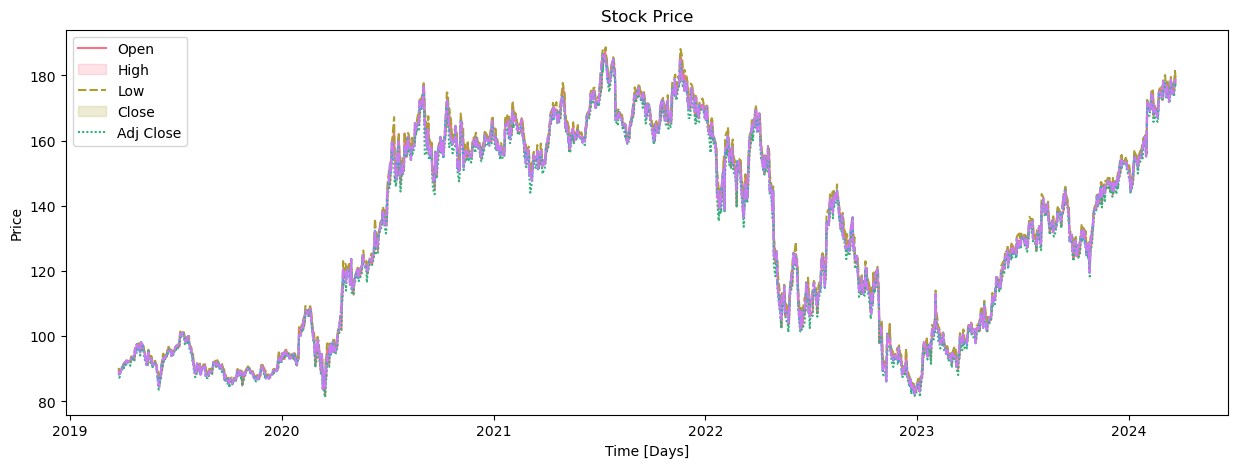

In [350]:
plt.figure(figsize=(15, 5))
palette = sns.color_palette("husl", 5)
sns.lineplot(data=dataset[['Open', 'High', 'Low', 'Close', 'Adj Close']],palette=palette) 
plt.title('Stock Price')
plt.xlabel('Time [Days]')
plt.ylabel('Price')
plt.legend(labels=['Open', 'High', 'Low', 'Close', 'Adj Close'], loc='best')
plt.show()

## Transform the data

Because we want to predict the **Close** price, we will scale the values from **Close** column, and we will use only this column for predicting.

In [352]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))

Splitting the data
X_train, y_train: Training set, used to train the model.

We define the number of time steps, which specifies the number of data points included in each sequence.

Next, we use the function create_sequences(scaled_data, sequence_length) to generate sequences for the training data. In this process, X holds the input sequences, while y holds the corresponding labels.

Following the creation of sequences, we proceed to split both X and y into training and testing sets.

In [353]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

**sequence_length** parameter determines how many data points are included in each sequence.

If we use a lower sequence_length, it means each sequence contains fewer data points. This might lead to less context being captured in each sequence, potentially resulting in a loss of information and less accurate predictions.

If we use a larger sequence_length, each sequence contains more data points. This allows the model to capture more context and patterns in the data, potentially leading to more accurate predictions

## Create Model LSTM

We create a sequential model using an LSTM layer followed by 4 Dense output layers


In [355]:
model = Sequential([
    LSTM(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

We create a function to save the model when it reach the best performaces, based on the validation loss.

In [356]:
def create_checkpoint(model_path):
   model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
   return model_checkpoint
    

We define the optimizer and compile the model, then we train the model.

In [357]:
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelLSTM.h5')])

Epoch 1/120


30/32 [===========================>..] - ETA: 0s - loss: 0.0443
Epoch 1: val_loss improved from inf to 0.00341, saving model to ModelLSTM.h5
32/32 [==============================] - 4s 28ms/step - loss: 0.0426 - val_loss: 0.0034
Epoch 2/120
15/32 [=============>................] - ETA: 0s - loss: 0.0027

/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/32 [===========================>..] - ETA: 0s - loss: 0.0025
Epoch 2: val_loss improved from 0.00341 to 0.00173, saving model to ModelLSTM.h5
32/32 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 3/120
30/32 [===========================>..] - ETA: 0s - loss: 0.0021 
Epoch 3: val_loss improved from 0.00173 to 0.00106, saving model to ModelLSTM.h5
32/32 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 4/120
32/32 [==============================] - ETA: 0s - loss: 0.0020
Epoch 4: val_loss improved from 0.00106 to 0.00098, saving model to ModelLSTM.h5
32/32 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 9.8272e-04
Epoch 5/120
32/32 [==============================] - ETA: 0s - loss: 0.0018 
Epoch 5: val_loss did not improve from 0.00098
32/32 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 6/120
29/32 [==========================>...] - ETA: 0s 

We load the model with the best validation loss.

In [358]:
model = tf.keras.models.load_model('ModelLSTM.h5')

We evaluate the model.

In [359]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.0007889577536843717
Test Loss: 0.0005976131069473922


We are using the same scaler to transform our scaled predictions back to normal values (prices)

In [360]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 7ms/step


We plot the prediction and the initial data

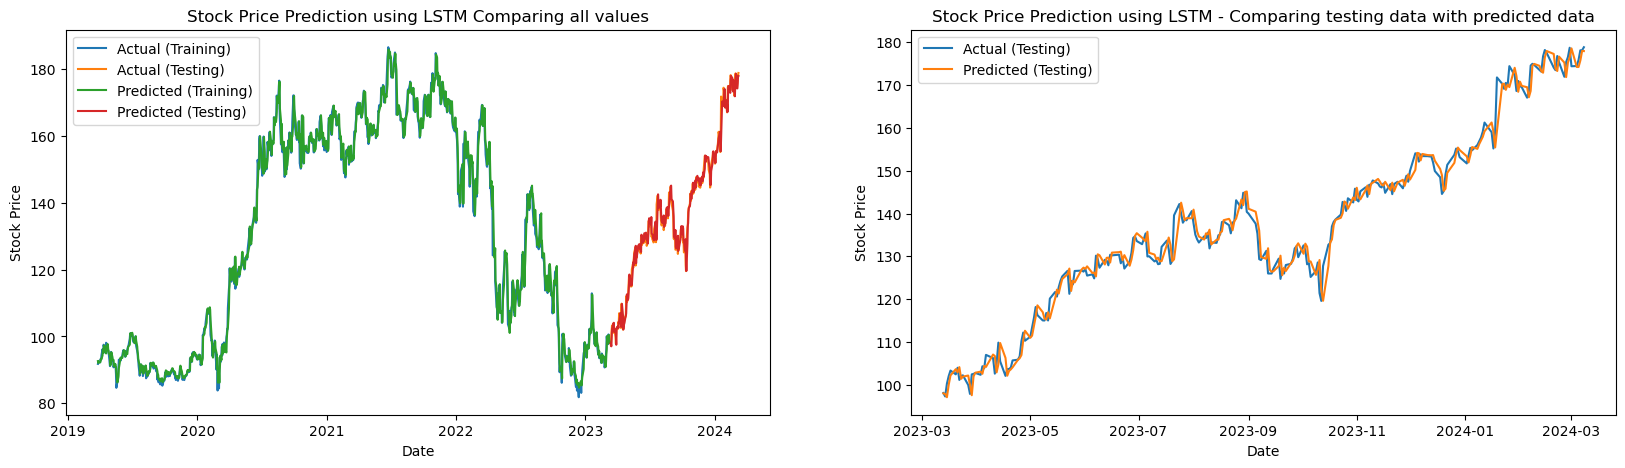

In [393]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[:len(train_predict)], train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(test_predict)], test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using LSTM Comparing all values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(1,2,2)
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(test_predict)], test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using LSTM - Comparing testing data with predicted data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## GRU model

We will create a GRU model to see how it will perform

In [362]:
gru_model = Sequential([
    GRU(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

Define optimizer, compile and train the model

In [363]:
learning_rate = 0.001

gru_model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

gru_model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelGRU.h5')])

Epoch 1/120
31/32 [============================>.] - ETA: 0s - loss: 0.0512
Epoch 1: val_loss improved from inf to 0.00079, saving model to ModelGRU.h5
32/32 [==============================] - 5s 35ms/step - loss: 0.0509 - val_loss: 7.8687e-04
Epoch 2/120
 5/32 [===>..........................] - ETA: 0s - loss: 0.0029    

/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/32 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 2: val_loss did not improve from 0.00079
32/32 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 3/120
32/32 [==============================] - ETA: 0s - loss: 0.0012
Epoch 3: val_loss did not improve from 0.00079
32/32 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 8.3079e-04
Epoch 4/120
28/32 [=========================>....] - ETA: 0s - loss: 0.0012
Epoch 4: val_loss improved from 0.00079 to 0.00070, saving model to ModelGRU.h5
32/32 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 6.9953e-04
Epoch 5/120
25/32 [======================>.......] - ETA: 0s - loss: 0.0011   
Epoch 5: val_loss did not improve from 0.00070
32/32 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 8.9602e-04
Epoch 6/120
25/32 [======================>.......] - ETA: 0s - loss: 0.0013
Epoch 6: val_loss did not improve from 0.0007

We load the best GRU saved model.

In [364]:
gru_model = tf.keras.models.load_model('ModelGRU.h5')

Evaluate the model.

In [365]:
# Evaluate the model
train_loss = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss = gru_model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.0007839268655516207
Test Loss: 0.0005963473813608289


We are using the same scaler to transform our scaled predictions back to normal values (prices)

In [366]:

gru_train_predict = gru_model.predict(X_train)
gru_test_predict = gru_model.predict(X_test)


gru_train_predict = scaler.inverse_transform(gru_train_predict)
gru_test_predict = scaler.inverse_transform(gru_test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 7ms/step


Plot the prediction and the initial data

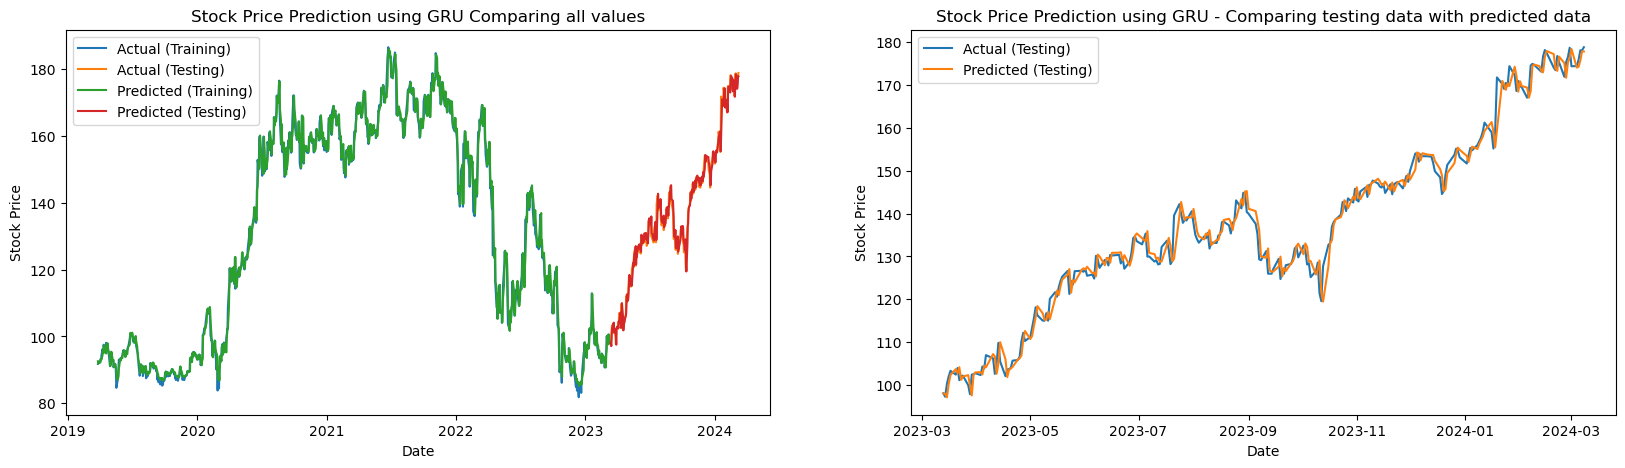

In [395]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[:len(gru_train_predict)], gru_train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(gru_test_predict)], gru_test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using GRU Comparing all values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(1,2,2)
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(gru_test_predict)], gru_test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using GRU - Comparing testing data with predicted data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## RNN Simple model

Here we will try to use a SimpleRNN Model

In [368]:
rnn_model = Sequential([
    SimpleRNN(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

Define optimizers, compile and train the model.

In [369]:
learning_rate = 0.001

rnn_model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

rnn_model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelSimpleRNN.h5')])

Epoch 1/120
28/32 [=========================>....] - ETA: 0s - loss: 0.0339
Epoch 1: val_loss improved from inf to 0.00241, saving model to ModelSimpleRNN.h5
32/32 [==============================] - 2s 20ms/step - loss: 0.0307 - val_loss: 0.0024
Epoch 2/120
32/32 [==============================] - ETA: 0s - loss: 0.0017
Epoch 2: val_loss improved from 0.00241 to 0.00082, saving model to ModelSimpleRNN.h5


/usr/local/Caskroom/miniconda/base/envs/stock-prediction-env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 8.1863e-04
Epoch 3/120
32/32 [==============================] - ETA: 0s - loss: 0.0014
Epoch 3: val_loss did not improve from 0.00082
32/32 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/120
17/32 [==============>...............] - ETA: 0s - loss: 0.0012
Epoch 4: val_loss improved from 0.00082 to 0.00076, saving model to ModelSimpleRNN.h5
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 7.6347e-04
Epoch 5/120
24/32 [=====================>........] - ETA: 0s - loss: 0.0012
Epoch 5: val_loss did not improve from 0.00076
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/120
28/32 [=========================>....] - ETA: 0s - loss: 0.0013
Epoch 6: val_loss improved from 0.00076 to 0.00075, saving model to ModelSimpleRNN.h5
32/32 [==============================] - 0s 11ms/step - loss: 0.0013 - val

Load the model.

In [370]:
rnn_model = tf.keras.models.load_model('ModelSimpleRNN.h5')

Evaluate the model.

In [371]:
train_loss = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.0007702805451117456
Test Loss: 0.000589525792747736


We are using the same scaler to transform our scaled predictions back to normal values (prices)

In [372]:
rnn_train_predict = rnn_model.predict(X_train)
rnn_test_predict = rnn_model.predict(X_test)

rnn_train_predict = scaler.inverse_transform(rnn_train_predict)
rnn_test_predict = scaler.inverse_transform(rnn_test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 2ms/step


Plot the prediction and actual values.

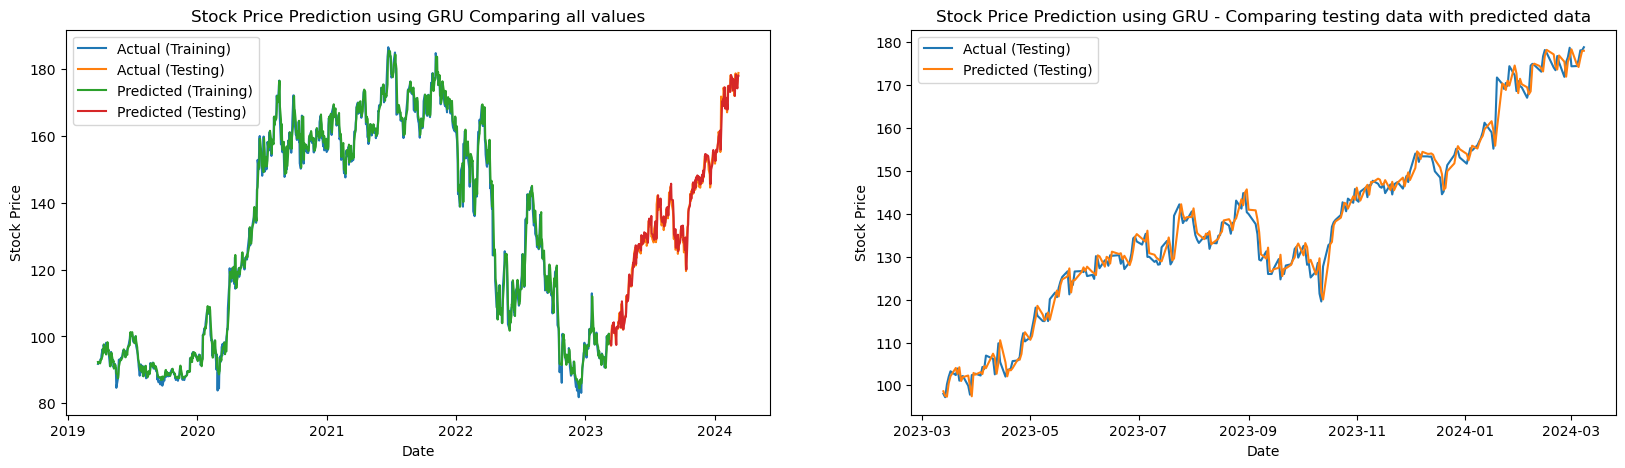

In [396]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[:len(rnn_train_predict)], rnn_train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(rnn_test_predict)], rnn_test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using RNN Comparing all values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(1,2,2)
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(rnn_test_predict)], rnn_test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using RNN - Comparing testing data with predicted data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Model comparison

Let's compare all 3 models with actual price from today.

In [374]:
last_predicted_close_lstm = test_predict[-1][0]
last_predicted_close_gru = gru_test_predict[-1][0]
last_predicted_close_rnn = rnn_test_predict[-1][0]

print("Actual price: ", actual_close)
print("LSTM Prediction: ", last_predicted_close_lstm)
print("GRU Prediction: ", last_predicted_close_gru)
print("RNN Prediction: ", last_predicted_close_rnn)

Actual price:  179.7100067138672
LSTM Prediction:  177.96695
GRU Prediction:  177.8664
RNN Prediction:  178.04623


Than we can choose a model and we can predict the next days Close prices.

In [400]:

number_of_days=10

last_sequence = X_test[-1]

last_sequence = last_sequence.reshape(1, sequence_length, 1)

predictions_next_days = []
for _ in range(number_of_days):
    next_day_prediction = model.predict(last_sequence, verbose=0)
    predictions_next_days.append(next_day_prediction[0, 0]) 
    last_sequence = np.roll(last_sequence, -1, axis=1) 
    last_sequence[0, -1, 0] = next_day_prediction[0, 0] 

predictions_next_days = scaler.inverse_transform(np.array(predictions_next_days).reshape(-1, 1))

print(f"Predictions for the next {number_of_days} days:")
for i, prediction in enumerate(predictions_next_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

Predictions for the next 10 days:
Day 1: Predicted Price = 177.96694946289062
Day 2: Predicted Price = 177.71762084960938
Day 3: Predicted Price = 177.46710205078125
Day 4: Predicted Price = 177.23170471191406
Day 5: Predicted Price = 177.01953125
Day 6: Predicted Price = 176.82630920410156
Day 7: Predicted Price = 176.6650848388672
Day 8: Predicted Price = 176.52871704101562
Day 9: Predicted Price = 176.4059600830078
Day 10: Predicted Price = 176.28485107421875
